This notebook demonstrates how to extract variables from the DMS eReef zarr for all GBR reefs.

In [1]:
import xarray as xr 
import geopandas as gpd 
import s3fs
import rioxarray # for the extension to load
import re
import pandas as pd 
import numpy as np
import logging


logger = logging.getLogger()
logging.basicConfig(level="INFO")

In [2]:
# Target variables that we want to extract from the data.zarr
variables = ["TOTAL_NITROGEN","Chl_a_sum","PhyL_Chl","PhyS_Chl","Oxy_sat","MA_N_pr","Secchi","Kd_490","DOR_P","DOR_N","DOR_C","salt","temp","TN","TC","TP"]

# Selecting the depth larger than 13, from -5.55m to surface
target_depth_min = 13
target_depth_max = 17

# 1. Extract Reef's shape file from DMS

In [3]:
# DMS reef shape path
reefshape_path = 's3://gbr-dms-data-public/gbrmpa-complete-gbr-features/data.parquet'
# Connecting to the S3 bucket where the GBR data is stored
reefshape = gpd.read_parquet(reefshape_path,
                            #Specifying which columns to read
                            columns = ['UNIQUE_ID', 'GBR_NAME', 'LOC_NAME_S', 'LEVEL_1', 'geometry'],
                            #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                            storage_options = {"anon": True}) 

# # Filtering the data to only include the Reef type
reefshape = reefshape[reefshape['LEVEL_1'] == 'Reef']

# Dropping duplicates based on the UNIQUE_ID column
reefshape.drop_duplicates(subset=['LOC_NAME_S'], inplace=True)
reefshape = reefshape.to_crs("EPSG:4326")
reefshape

,UNIQUE_ID,GBR_NAME,LOC_NAME_S,LEVEL_1,geometry
fid,,,,,
459,09361104104,U/N Reef,U/N Reef (09-361d),Reef,"POLYGON ((143.22825 -9.2641, 143.22802 -9.2641..."
460,09361104100,U/N Reef,U/N Reef (09-361),Reef,"POLYGON ((143.23613 -9.26759, 143.23502 -9.267..."
461,09361104102,U/N Reef,U/N Reef (09-361b),Reef,"POLYGON ((143.23517 -9.26074, 143.23577 -9.261..."
462,09361104103,U/N Reef,U/N Reef (09-361c),Reef,"POLYGON ((143.228 -9.26056, 143.2274 -9.26077,..."
463,09361104105,U/N Reef,U/N Reef (09-361e),Reef,"POLYGON ((143.21933 -9.25797, 143.21873 -9.257..."
...,...,...,...,...,...
9601,10510109102,Mainland,Mainland (10-510b),Reef,"POLYGON ((142.39805 -10.803, 142.39708 -10.802..."
9602,10510109103,Mainland,Mainland (10-510c),Reef,"POLYGON ((142.36692 -10.84571, 142.3666 -10.84..."
9609,10258106100,Quetta Rock,Quetta Rock (10-258),Reef,"POLYGON ((142.62941 -10.67, 142.62927 -10.6696..."


There are 7053 reefs.

# 2. Extract source vairables from DMS eReef zarr

In [4]:
zarr_path = "s3://gbr-dms-data-public/aims-ereefs-biogeochem-baseline-daily-monthly/data.zarr/"

fs = s3fs.S3FileSystem(anon=True)
data = xr.open_zarr(s3fs.S3Map(zarr_path, s3=fs), consolidated=True)

# Selecting the depth larger than 13, from -5.55m to surface
data = data.sel(k=slice(target_depth_min, target_depth_max))

data = data[variables]
data

<xarray.Dataset> Size: 253GB
Dimensions:         (time: 3073, k: 4, latitude: 723, longitude: 491)
Coordinates:
  * latitude        (latitude) float64 6kB -28.7 -28.67 -28.64 ... -7.066 -7.036
  * longitude       (longitude) float64 4kB 142.2 142.2 142.2 ... 156.8 156.9
  * time            (time) datetime64[ns] 25kB 2010-12-01T02:00:00 ... 2019-0...
    zc              (k) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
Dimensions without coordinates: k
Data variables: (12/16)
    TOTAL_NITROGEN  (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    Chl_a_sum       (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    PhyL_Chl        (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    PhyS_Chl        (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    Oxy_sat         (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    MA_N_pr         (time, latitude, longitude) float32 4GB dask.array<chunksize=(1, 723, 491), meta=np.ndarray>
    ...              ...
    DOR_C           (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    salt            (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    temp            (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    TN              (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    TC              (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
    TP              (time, k, latitude, longitude) float32 17GB dask.array<chunksize=(1, 4, 723, 491), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                   CF-1.0
    NCO:                           netCDF Operators version 4.7.7 (Homepage =...
    RunID:                         2
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:    2021-09-07T21:05:18+10:00
    aims_ncaggregate_datasetId:    products__ncaggregate__ereefs__GBR4_H2p0_B...
    ...                            ...
    metadata_link:                 https://eatlas.org.au/data/uuid/61f3a6df-2...
    paramfile:                     /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_Cb/...
    paramhead:                     eReefs 4 km grid. SOURCE Catchments with 2...
    technical_guide_link:          https://eatlas.org.au/pydio/public/aims-er...
    technical_guide_publish_date:  2020-08-18
    title:                         eReefs AIMS-CSIRO GBR4 BioGeoChemical 3.1 ...

# 3. Preview of the reef shape and zarr 
Before we move to the extraction of zarr variables that are specific to GBR reefs, let's demo how we extract one reef's variables from zarr first. We will take Tongue Reef as an example.

In [5]:
# Extract the reefshape from the GBR data by using the UNIQUE_ID
reefshape_UNIQUE_ID = '16026100104' # Example UNIQUE_ID representing a reef, here is Tongue Reef.
reefshape_i = reefshape[reefshape['UNIQUE_ID'] == reefshape_UNIQUE_ID]
reefshape_i

,UNIQUE_ID,GBR_NAME,LOC_NAME_S,LEVEL_1,geometry
fid,,,,,
4757,16026100104,Tongue Reef,Tongue Reef (16-026),Reef,"POLYGON ((145.64465 -16.25114, 145.64663 -16.2..."


<Axes: >

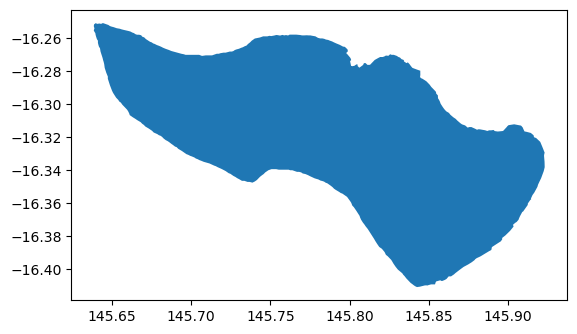

In [6]:
# Plot the reefshape of the Tongue Reef
reefshape_i.plot()

Here, we select the data of Tongue Reef from the DMS eReef zarr by clipping the reef's shape on the zarr.

In [7]:
# Pick the first day of the data to do the clipping
reef_sample = data.isel(time=0)

# Clip the data.zarr to the reef shape
region_gdf = reefshape_i

reef_sample.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

reef_sample.rio.write_crs("epsg:4326", inplace=True)

data_clipped = reef_sample.rio.clip(region_gdf.geometry.values, region_gdf.crs, drop=True, all_touched=True)

data_clipped

<xarray.Dataset> Size: 14kB
Dimensions:         (latitude: 6, longitude: 10, k: 4)
Coordinates:
  * latitude        (latitude) float64 48B -16.4 -16.37 -16.34 ... -16.28 -16.25
  * longitude       (longitude) float64 80B 145.6 145.7 145.7 ... 145.9 145.9
    time            datetime64[ns] 8B 2010-12-01T02:00:00
    zc              (k) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
    spatial_ref     int64 8B 0
Dimensions without coordinates: k
Data variables: (12/16)
    TOTAL_NITROGEN  (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    Chl_a_sum       (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    PhyL_Chl        (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    PhyS_Chl        (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    Oxy_sat         (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    MA_N_pr         (latitude, longitude) float32 240B dask.array<chunksize=(6, 10), meta=np.ndarray>
    ...              ...
    DOR_C           (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    salt            (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    temp            (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    TN              (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    TC              (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
    TP              (k, latitude, longitude) float32 960B dask.array<chunksize=(4, 6, 10), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                   CF-1.0
    NCO:                           netCDF Operators version 4.7.7 (Homepage =...
    RunID:                         2
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:    2021-09-07T21:05:18+10:00
    aims_ncaggregate_datasetId:    products__ncaggregate__ereefs__GBR4_H2p0_B...
    ...                            ...
    metadata_link:                 https://eatlas.org.au/data/uuid/61f3a6df-2...
    paramfile:                     /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_Cb/...
    paramhead:                     eReefs 4 km grid. SOURCE Catchments with 2...
    technical_guide_link:          https://eatlas.org.au/pydio/public/aims-er...
    technical_guide_publish_date:  2020-08-18
    title:                         eReefs AIMS-CSIRO GBR4 BioGeoChemical 3.1 ...

Now, we get the zarr that only focuses on the region of Tongue Reef. Let's plot it.


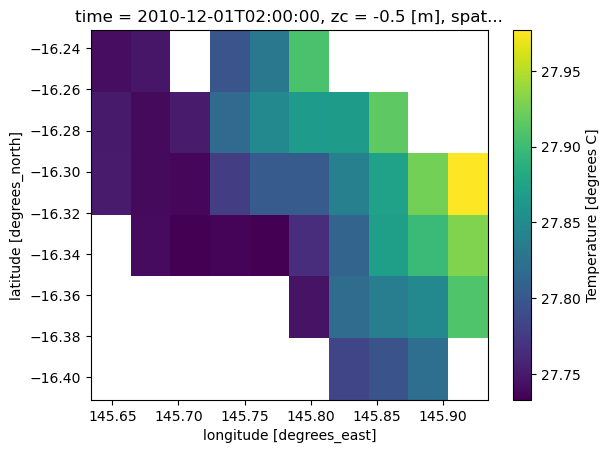

In [8]:
# Plot the temperature at the target depth
target_depth = 3 # level 3 is the depth of -0.50m

data_clipped.temp.isel(k=target_depth).plot()

From the clipped zarr of the reef shape, we can extract any variables at any time and depth. Now, we will move to extract variables from zarr for all 7035 reefs.


# 4. Extract data for all reefs 
## 4.1 Build Reef Cells Dimension Table
We need to build a dimension table that stores the UNIQUE_ID, ROWID (represent the unique cell of a reef) of reefs and the corresponding centroid latitude and longitude of the cell that the reef is located in. We ill use this tale to build final denormalized parquet.


For your convenience, you can access the completed reef_cells dimension table from DMS directly.


In [30]:
dim_reef_cells = pd.read_parquet("s3://rimrep-data-public-development/cots-ereef-biogeochemistry-daily-monthly/dim_tables/dim_reef_cells.parquet", storage_options={"anon": True})
## TODO: move the s3 path to production environment
dim_reef_cells

,UNIQUE_ID,ROWID,Latitude,Longitude
0,09361104104,0,-9.256022,143.218788
1,09361104100,0,-9.256022,143.218788
2,09361104100,1,-9.256022,143.248788
3,09361104102,0,-9.256022,143.218788
4,09361104102,1,-9.256022,143.248788
...,...,...,...,...
19195,10510109103,0,-10.846022,142.378788
19196,10510109103,1,-10.816022,142.378788
19197,10510109103,2,-10.846022,142.408788
19198,10510109103,3,-10.816022,142.408788


Or you can use the following functions to build the reef_cells dimension table in your local machine.

In [12]:
# Create a slice of data to produce mask of the reef
reef_sample = data.isel(time=-2).isel(k=1)[[ 'salt']]

var = reef_sample['salt']

# Verify the shape
if var.shape == (723, 491):
    # Overwrite all values by 1 and avoid None values
    # No None value returning will help us to get complete whole region of all reefs
    for i in range(var.shape[0]):
        var[i, :] = 1

reef_sample

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 723, longitude: 491)
Coordinates:
  * latitude   (latitude) float64 6kB -28.7 -28.67 -28.64 ... -7.066 -7.036
  * longitude  (longitude) float64 4kB 142.2 142.2 142.2 ... 156.8 156.8 156.9
    time       datetime64[ns] 8B 2019-04-29T02:00:00
    zc         float64 8B dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    salt       (latitude, longitude) float32 1MB dask.array<chunksize=(723, 491), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                   CF-1.0
    NCO:                           netCDF Operators version 4.7.7 (Homepage =...
    RunID:                         2
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:    2021-09-07T21:05:18+10:00
    aims_ncaggregate_datasetId:    products__ncaggregate__ereefs__GBR4_H2p0_B...
    ...                            ...
    metadata_link:                 https://eatlas.org.au/data/uuid/61f3a6df-2...
    paramfile:                     /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_Cb/...
    paramhead:                     eReefs 4 km grid. SOURCE Catchments with 2...
    technical_guide_link:          https://eatlas.org.au/pydio/public/aims-er...
    technical_guide_publish_date:  2020-08-18
    title:                         eReefs AIMS-CSIRO GBR4 BioGeoChemical 3.1 ...

In [48]:
## create n array of ones based on data shape
mask = np.ones(var.shape)
mask

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [13]:
def build_a_reef_cell_table(
    reefshape_UNIQUE_ID: str,
    data: xr.Dataset,
    reefshape: gpd.GeoDataFrame
) -> pd.DataFrame:
    """
    Builds a table mapping dataset cells to reef geometry features.

    Parameters:
    reefshape_UNIQUE_ID (str): The unique identifier for reef features in the GeoDataFrame.
    data (xr.Dataset): The dataset containing spatial data with latitude and longitude coordinates.
    reefshape (gpd.GeoDataFrame): A GeoDataFrame containing reef geometries.

    Returns:
    pd.DataFrame: A DataFrame mapping data points to reef geometries.
    """
    
    print(reefshape_UNIQUE_ID)
    # Extract the reefshape from the GBR data by using the UNIQUE_ID
    reefshape_i = reefshape[reefshape['UNIQUE_ID'] == reefshape_UNIQUE_ID]

    # Clip the data.zarr to the reef shape
    region_gdf = reefshape_i

    data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

    data.rio.write_crs("epsg:4326", inplace=True)

    try :
        data_clipped = data.rio.clip(region_gdf.geometry.values, region_gdf.crs, drop=True, all_touched=True)

        # Extract the lat and lon of the reef
        lat = data_clipped.latitude.values
        lon = data_clipped.longitude.values
        print(lat, lon)


        # Create cross combinations using numpy's meshgrid
        lat_grid, lon_grid = np.meshgrid(lat, lon)

        # Flatten the grids and combine them
        reef_cells = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])

        # Create a DataFrame for better visualization
        df_reef_cells = pd.DataFrame(reef_cells, columns=['Latitude', 'Longitude'])

        df_reef_cells['UNIQUE_ID'] = reefshape_UNIQUE_ID
        df_reef_cells['ROWID'] = df_reef_cells.index
        df_reef_cells = df_reef_cells[['UNIQUE_ID', 'ROWID', 'Latitude', 'Longitude']]
        
        return df_reef_cells
    except:
        print("The geometry of reef is out of the source xr.dataset bounds")
        return None

In [14]:
def build_all_reef_cells_dim_table(
    data: xr.Dataset,
    reefshape: gpd.GeoDataFrame
) -> pd.DataFrame:
    """
    Builds a table mapping dataset cells coordinates to reef geometry features.

    Parameters:
    data (xr.Dataset): The dataset containing spatial data with latitude and longitude coordinates.
    reefshape (gpd.GeoDataFrame): A GeoDataFrame containing reef geometries.

    Returns:
    pd.DataFrame: A DataFrame mapping data points to reef geometries.
    """
    
    reef_cells = pd.DataFrame()
    
    for reefshape_UNIQUE_ID in reefshape['UNIQUE_ID']:
        # extract the reef cells for each reef depth
        a_reef_cell = build_a_reef_cell_table(reefshape_UNIQUE_ID, data, reefshape)
        reef_cells = pd.concat([reef_cells, a_reef_cell],ignore_index=True) 
    return reef_cells

### Start to build the dimension table of reef_cells

In [15]:
# Recommend running this code in a cloud environment with more memory

zarr_path = "s3://gbr-dms-data-public/aims-ereefs-biogeochem-baseline-daily-monthly/data.zarr/"

fs = s3fs.S3FileSystem(anon=True)
data = xr.open_zarr(s3fs.S3Map(zarr_path, s3=fs), consolidated=True)

# Selecting the depth larger than 13, from -5.55m to surface
data = data.sel(k=slice(target_depth_min, target_depth_max))

data = data[variables]

# Create a sample xr.dataset to exclude none values
# create a new variable
reef_sample = data.isel(time=-2).isel(k=1)[[ 'salt']]

var = reef_sample['salt']

# Verify the shape
if var.shape == (723, 491):
    # Overwrite all values in chunks to manage memory efficiently
    for i in range(var.shape[0]):
        var[i, :] = 1


# Build the dim_reef_cells table and save it to parquet
dim_reef_cells = build_all_reef_cells_dim_table(reef_sample, reefshape)
dim_reef_cells.to_parquet("dim_reef_cells.parquet")

09361104104
[-9.256022] [143.218788]
09361104100
[-9.256022] [143.218788 143.248788]
09361104102
[-9.256022] [143.218788 143.248788]
09361104103
[-9.256022] [143.218788]
09361104105
[-9.256022] [143.218788]
09361104106
[-9.256022] [143.218788]
09361104101
[-9.256022] [143.218788 143.248788]
09354104100
[-9.256022] [143.128788]
09343104106
[-9.286022] [143.008788]
09343104105
[-9.286022] [143.008788]
09343104103
[-9.286022] [143.008788]
09343104102
[-9.286022] [143.008788]
09343104104
[-9.286022 -9.256022] [143.008788]
09343104100
[-9.286022 -9.256022] [143.008788 143.038788]
09343104101
[-9.286022 -9.256022] [143.038788]
09359104100
[-9.286022] [143.218788]
09363104109
[-9.316022] [143.278788]
09363104106
[-9.316022] [143.278788]
09363104108
[-9.316022] [143.278788]
09363104104
[-9.316022] [143.278788]
09363104103
[-9.316022] [143.278788]
09363104102
[-9.316022 -9.286022] [143.248788 143.278788]
09363104110
[-9.286022] [143.248788 143.278788]
09363104101
[-9.286022] [143.248788]
093631

## 4.2 Build the units dimension table

Prepare units of variables and we will map the unites value back to the variables of final table later.

In [16]:
# Build the unites dimension table
def build_units_dim_table(
    data: xr.Dataset
) -> pd.DataFrame:
    """
    Builds a table mapping dataset cells to reef geometry features.

    Parameters:
    data (xr.Dataset): The dataset containing spatial data with latitude and longitude coordinates.

    Returns:
    pd.DataFrame: A DataFrame mapping data points to reef geometries.
    """
        
    # Extracting the units of the variables
    units = []
    for i in data.variables:
        if i in data.coords:
            continue
        # store the units in a dictionary 
        var_units = {i: data[i].attrs['units']}
        units.append(var_units)

    # Build units dataframe for referencing the units of the variables
    units_df = pd.DataFrame([(key, value) for dic in units for key, value in dic.items()], columns=['Variable', 'Unit'])

    return units_df


In [17]:
# Build the units dimension table
units_df = build_units_dim_table(data)
units_df.to_parquet("./data/dim_units.parquet")

## 4.3 Extract the variables values from the GBR data for all reefs 
Let's demo to extract a day of all reefs here. 

Now, lets re clip zarr of all reefs instead of only Tongue Reef.

In [18]:
# Clip the data.zarr to the reef shape 
region_gdf = reefshape

data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

data.rio.write_crs("epsg:4326", inplace=True)

data_clipped = data.rio.clip(region_gdf.geometry.values, region_gdf.crs, drop=True, all_touched=True)
data_clipped = data_clipped.drop_vars('spatial_ref')

data_clipped

<xarray.Dataset> Size: 138GB
Dimensions:         (latitude: 525, longitude: 368, time: 3073, k: 4)
Coordinates:
  * latitude        (latitude) float64 4kB -24.68 -24.65 ... -8.986 -8.956
  * longitude       (longitude) float64 3kB 142.2 142.2 142.2 ... 153.1 153.2
  * time            (time) datetime64[ns] 25kB 2010-12-01T02:00:00 ... 2019-0...
    zc              (k) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
Dimensions without coordinates: k
Data variables: (12/16)
    TOTAL_NITROGEN  (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    Chl_a_sum       (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    PhyL_Chl        (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    PhyS_Chl        (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    Oxy_sat         (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    MA_N_pr         (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 525, 368), meta=np.ndarray>
    ...              ...
    DOR_C           (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    salt            (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    temp            (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    TN              (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    TC              (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    TP              (time, k, latitude, longitude) float32 9GB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                   CF-1.0
    NCO:                           netCDF Operators version 4.7.7 (Homepage =...
    RunID:                         2
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:    2021-09-07T21:05:18+10:00
    aims_ncaggregate_datasetId:    products__ncaggregate__ereefs__GBR4_H2p0_B...
    ...                            ...
    metadata_link:                 https://eatlas.org.au/data/uuid/61f3a6df-2...
    paramfile:                     /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_Cb/...
    paramhead:                     eReefs 4 km grid. SOURCE Catchments with 2...
    technical_guide_link:          https://eatlas.org.au/pydio/public/aims-er...
    technical_guide_publish_date:  2020-08-18
    title:                         eReefs AIMS-CSIRO GBR4 BioGeoChemical 3.1 ...

Let select 2011-01-01 to extract all reefs data from zarr as the memory required is relatively small.

In [19]:
selected_time = "2011-01-01"
# Build the dataframe for the raw data (Test by daily data)
all_reef_cells_201101 = data_clipped.sel(time=selected_time)

# You can also try to select monthly data by simply drop day from the selected_time
# all_reef_cells_201101 = data_clipped.sel(time="2011-01")
print(all_reef_cells_201101.nbytes / 1e9)
all_reef_cells_201101

0.044829584


<xarray.Dataset> Size: 45MB
Dimensions:         (latitude: 525, longitude: 368, time: 1, k: 4)
Coordinates:
  * latitude        (latitude) float64 4kB -24.68 -24.65 ... -8.986 -8.956
  * longitude       (longitude) float64 3kB 142.2 142.2 142.2 ... 153.1 153.2
  * time            (time) datetime64[ns] 8B 2011-01-01T02:00:00
    zc              (k) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
Dimensions without coordinates: k
Data variables: (12/16)
    TOTAL_NITROGEN  (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    Chl_a_sum       (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    PhyL_Chl        (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    PhyS_Chl        (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    Oxy_sat         (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    MA_N_pr         (time, latitude, longitude) float32 773kB dask.array<chunksize=(1, 525, 368), meta=np.ndarray>
    ...              ...
    DOR_C           (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    salt            (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    temp            (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    TN              (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    TC              (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
    TP              (time, k, latitude, longitude) float32 3MB dask.array<chunksize=(1, 4, 525, 368), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                   CF-1.0
    NCO:                           netCDF Operators version 4.7.7 (Homepage =...
    RunID:                         2
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:    2021-09-07T21:05:18+10:00
    aims_ncaggregate_datasetId:    products__ncaggregate__ereefs__GBR4_H2p0_B...
    ...                            ...
    metadata_link:                 https://eatlas.org.au/data/uuid/61f3a6df-2...
    paramfile:                     /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_Cb/...
    paramhead:                     eReefs 4 km grid. SOURCE Catchments with 2...
    technical_guide_link:          https://eatlas.org.au/pydio/public/aims-er...
    technical_guide_publish_date:  2020-08-18
    title:                         eReefs AIMS-CSIRO GBR4 BioGeoChemical 3.1 ...

# 5. Build the final denormalized table of all reefs

In [20]:
# Build the dataframe for the raw data (Test by daily data)
df_all_reef_cells_201101 = all_reef_cells_201101.to_dataframe()
df_all_reef_cells_201101.reset_index(inplace=True)
df_all_reef_cells_201101

,latitude,longitude,time,k,zc,TOTAL_NITROGEN,Chl_a_sum,PhyL_Chl,PhyS_Chl,Oxy_sat,...,Secchi,Kd_490,DOR_P,DOR_N,DOR_C,salt,temp,TN,TC,TP
0,-24.676022,142.168788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-24.676022,142.168788,2011-01-01 02:00:00,1,-3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-24.676022,142.168788,2011-01-01 02:00:00,2,-1.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-24.676022,142.168788,2011-01-01 02:00:00,3,-0.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-24.676022,142.198788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772795,-8.956022,153.148788,2011-01-01 02:00:00,3,-0.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772796,-8.956022,153.178788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772797,-8.956022,153.178788,2011-01-01 02:00:00,1,-3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772798,-8.956022,153.178788,2011-01-01 02:00:00,2,-1.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Rename the columns to match the schema
df_all_reef_cells_201101.rename(columns={'time': 'Time', 'zc': 'Depth', 'latitude': 'Latitude', 'longitude': 'Longitude'}, inplace=True)
df_all_reef_cells_201101

,Latitude,Longitude,Time,k,Depth,TOTAL_NITROGEN,Chl_a_sum,PhyL_Chl,PhyS_Chl,Oxy_sat,...,Secchi,Kd_490,DOR_P,DOR_N,DOR_C,salt,temp,TN,TC,TP
0,-24.676022,142.168788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-24.676022,142.168788,2011-01-01 02:00:00,1,-3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-24.676022,142.168788,2011-01-01 02:00:00,2,-1.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-24.676022,142.168788,2011-01-01 02:00:00,3,-0.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-24.676022,142.198788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772795,-8.956022,153.148788,2011-01-01 02:00:00,3,-0.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772796,-8.956022,153.178788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772797,-8.956022,153.178788,2011-01-01 02:00:00,1,-3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772798,-8.956022,153.178788,2011-01-01 02:00:00,2,-1.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Merge the raw data with the dim_reef_cells table
df_all_reef_cells = pd.merge(df_all_reef_cells_201101, dim_reef_cells, on=['Latitude', 'Longitude'], how='left')
df_all_reef_cells

,Latitude,Longitude,Time,k,Depth,TOTAL_NITROGEN,Chl_a_sum,PhyL_Chl,PhyS_Chl,Oxy_sat,...,DOR_P,DOR_N,DOR_C,salt,temp,TN,TC,TP,UNIQUE_ID,ROWID
0,-24.676022,142.168788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-24.676022,142.168788,2011-01-01 02:00:00,1,-3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-24.676022,142.168788,2011-01-01 02:00:00,2,-1.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-24.676022,142.168788,2011-01-01 02:00:00,3,-0.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-24.676022,142.198788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808135,-8.956022,153.148788,2011-01-01 02:00:00,3,-0.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
808136,-8.956022,153.178788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
808137,-8.956022,153.178788,2011-01-01 02:00:00,1,-3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
808138,-8.956022,153.178788,2011-01-01 02:00:00,2,-1.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Drop nan values for the UNIQUE_ID
df_all_reef_cells.dropna(subset=['UNIQUE_ID'], inplace=True)
df_all_reef_cells['ROWID'] = df_all_reef_cells['ROWID'].astype(int)
df_all_reef_cells

,Latitude,Longitude,Time,k,Depth,TOTAL_NITROGEN,Chl_a_sum,PhyL_Chl,PhyS_Chl,Oxy_sat,...,DOR_P,DOR_N,DOR_C,salt,temp,TN,TC,TP,UNIQUE_ID,ROWID
1460,-24.676022,153.118788,2011-01-01 02:00:00,0,-5.55,103.052864,0.603638,0.051040,0.509003,105.948944,...,6.792882,85.616928,493.888672,35.026863,26.160358,103.052864,23799.421875,11.705717,24011100104,0
1461,-24.676022,153.118788,2011-01-01 02:00:00,1,-3.00,103.127739,0.584620,0.048444,0.492683,106.066078,...,6.819602,85.988037,496.236755,35.017902,26.247559,103.127739,23807.337891,11.729089,24011100104,0
1462,-24.676022,153.118788,2011-01-01 02:00:00,2,-1.50,103.100655,0.577228,0.046946,0.486824,106.124107,...,6.829669,86.127068,497.114471,35.011177,26.297764,103.100655,23809.882812,11.729235,24011100104,0
1463,-24.676022,153.118788,2011-01-01 02:00:00,3,-0.50,103.042152,0.574071,0.045985,0.484656,105.945930,...,6.832271,86.162849,497.339050,35.008076,26.317865,103.042152,23812.091797,11.720840,24011100104,0
1464,-24.676022,153.148788,2011-01-01 02:00:00,0,-5.55,105.523041,0.611106,0.052796,0.513994,106.205475,...,6.956481,87.721603,506.764679,34.999569,26.147318,105.523041,23846.794922,12.217728,24011100104,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806843,-8.956022,143.458788,2011-01-01 02:00:00,3,-0.50,527.036987,0.434805,0.019378,0.338729,122.125183,...,19.155191,382.865875,2938.741455,21.248373,29.601957,527.036987,18169.501953,31.612307,09415104101,11
806844,-8.956022,143.488788,2011-01-01 02:00:00,0,-5.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09415104101,17
806845,-8.956022,143.488788,2011-01-01 02:00:00,1,-3.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09415104101,17
806846,-8.956022,143.488788,2011-01-01 02:00:00,2,-1.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09415104101,17


In [24]:
# Drop the k column as it is not needed
df_all_reef_cells.drop(columns=['k'], inplace=True)

# Melt the dataframe to have the variables in a single column
df_all_reef_cells = df_all_reef_cells.melt(id_vars=['Time','UNIQUE_ID','ROWID', 'Depth', 'Latitude', 'Longitude'], var_name='Variable', value_name='Value')
# We could treat this table as a fact table basically
df_all_reef_cells

,Time,UNIQUE_ID,ROWID,Depth,Latitude,Longitude,Variable,Value
0,2011-01-01 02:00:00,24011100104,0,-5.55,-24.676022,153.118788,TOTAL_NITROGEN,103.052864
1,2011-01-01 02:00:00,24011100104,0,-3.00,-24.676022,153.118788,TOTAL_NITROGEN,103.127739
2,2011-01-01 02:00:00,24011100104,0,-1.50,-24.676022,153.118788,TOTAL_NITROGEN,103.100655
3,2011-01-01 02:00:00,24011100104,0,-0.50,-24.676022,153.118788,TOTAL_NITROGEN,103.042152
4,2011-01-01 02:00:00,24011100104,3,-5.55,-24.676022,153.148788,TOTAL_NITROGEN,105.523041
...,...,...,...,...,...,...,...,...
1232123,2011-01-01 02:00:00,09415104101,11,-0.50,-8.956022,143.458788,TP,31.612307
1232124,2011-01-01 02:00:00,09415104101,17,-5.55,-8.956022,143.488788,TP,NaN
1232125,2011-01-01 02:00:00,09415104101,17,-3.00,-8.956022,143.488788,TP,NaN
1232126,2011-01-01 02:00:00,09415104101,17,-1.50,-8.956022,143.488788,TP,NaN


In [25]:
# Convert time to date
df_all_reef_cells['Date'] = df_all_reef_cells['Time'].dt.date

# Drop the time column as it is not needed
df_all_reef_cells.drop(columns=['Time'], inplace=True)
df_all_reef_cells

,UNIQUE_ID,ROWID,Depth,Latitude,Longitude,Variable,Value,Date
0,24011100104,0,-5.55,-24.676022,153.118788,TOTAL_NITROGEN,103.052864,2011-01-01
1,24011100104,0,-3.00,-24.676022,153.118788,TOTAL_NITROGEN,103.127739,2011-01-01
2,24011100104,0,-1.50,-24.676022,153.118788,TOTAL_NITROGEN,103.100655,2011-01-01
3,24011100104,0,-0.50,-24.676022,153.118788,TOTAL_NITROGEN,103.042152,2011-01-01
4,24011100104,3,-5.55,-24.676022,153.148788,TOTAL_NITROGEN,105.523041,2011-01-01
...,...,...,...,...,...,...,...,...
1232123,09415104101,11,-0.50,-8.956022,143.458788,TP,31.612307,2011-01-01
1232124,09415104101,17,-5.55,-8.956022,143.488788,TP,NaN,2011-01-01
1232125,09415104101,17,-3.00,-8.956022,143.488788,TP,NaN,2011-01-01
1232126,09415104101,17,-1.50,-8.956022,143.488788,TP,NaN,2011-01-01


In [26]:
# Add the reef name to the table
df_all_reef_cells = pd.merge(df_all_reef_cells, reefshape[['UNIQUE_ID', 'LOC_NAME_S']], left_on='UNIQUE_ID', right_on='UNIQUE_ID', how='left')
df_all_reef_cells

,UNIQUE_ID,ROWID,Depth,Latitude,Longitude,Variable,Value,Date,LOC_NAME_S
0,24011100104,0,-5.55,-24.676022,153.118788,TOTAL_NITROGEN,103.052864,2011-01-01,Porpoise Shoal (24-011)
1,24011100104,0,-3.00,-24.676022,153.118788,TOTAL_NITROGEN,103.127739,2011-01-01,Porpoise Shoal (24-011)
2,24011100104,0,-1.50,-24.676022,153.118788,TOTAL_NITROGEN,103.100655,2011-01-01,Porpoise Shoal (24-011)
3,24011100104,0,-0.50,-24.676022,153.118788,TOTAL_NITROGEN,103.042152,2011-01-01,Porpoise Shoal (24-011)
4,24011100104,3,-5.55,-24.676022,153.148788,TOTAL_NITROGEN,105.523041,2011-01-01,Porpoise Shoal (24-011)
...,...,...,...,...,...,...,...,...,...
1232123,09415104101,11,-0.50,-8.956022,143.458788,TP,31.612307,2011-01-01,U/N Reef (09-415a)
1232124,09415104101,17,-5.55,-8.956022,143.488788,TP,NaN,2011-01-01,U/N Reef (09-415a)
1232125,09415104101,17,-3.00,-8.956022,143.488788,TP,NaN,2011-01-01,U/N Reef (09-415a)
1232126,09415104101,17,-1.50,-8.956022,143.488788,TP,NaN,2011-01-01,U/N Reef (09-415a)


In [27]:
# Add units into the main table
df_all_reef_cells = pd.merge(df_all_reef_cells, units_df, on='Variable', how='left')
df_all_reef_cells

,UNIQUE_ID,ROWID,Depth,Latitude,Longitude,Variable,Value,Date,LOC_NAME_S,Unit
0,24011100104,0,-5.55,-24.676022,153.118788,TOTAL_NITROGEN,103.052864,2011-01-01,Porpoise Shoal (24-011),mg N m-3
1,24011100104,0,-3.00,-24.676022,153.118788,TOTAL_NITROGEN,103.127739,2011-01-01,Porpoise Shoal (24-011),mg N m-3
2,24011100104,0,-1.50,-24.676022,153.118788,TOTAL_NITROGEN,103.100655,2011-01-01,Porpoise Shoal (24-011),mg N m-3
3,24011100104,0,-0.50,-24.676022,153.118788,TOTAL_NITROGEN,103.042152,2011-01-01,Porpoise Shoal (24-011),mg N m-3
4,24011100104,3,-5.55,-24.676022,153.148788,TOTAL_NITROGEN,105.523041,2011-01-01,Porpoise Shoal (24-011),mg N m-3
...,...,...,...,...,...,...,...,...,...,...
1232123,09415104101,11,-0.50,-8.956022,143.458788,TP,31.612307,2011-01-01,U/N Reef (09-415a),mg P m-3
1232124,09415104101,17,-5.55,-8.956022,143.488788,TP,NaN,2011-01-01,U/N Reef (09-415a),mg P m-3
1232125,09415104101,17,-3.00,-8.956022,143.488788,TP,NaN,2011-01-01,U/N Reef (09-415a),mg P m-3
1232126,09415104101,17,-1.50,-8.956022,143.488788,TP,NaN,2011-01-01,U/N Reef (09-415a),mg P m-3


In [28]:
# Reorder the columns
df_all_reef_cells = df_all_reef_cells[['UNIQUE_ID', 'ROWID', 'Latitude', 'Longitude', 'LOC_NAME_S', 'Depth', 'Variable', 'Unit', 'Date', 'Value']]
df_all_reef_cells

,UNIQUE_ID,ROWID,Latitude,Longitude,LOC_NAME_S,Depth,Variable,Unit,Date,Value
0,24011100104,0,-24.676022,153.118788,Porpoise Shoal (24-011),-5.55,TOTAL_NITROGEN,mg N m-3,2011-01-01,103.052864
1,24011100104,0,-24.676022,153.118788,Porpoise Shoal (24-011),-3.00,TOTAL_NITROGEN,mg N m-3,2011-01-01,103.127739
2,24011100104,0,-24.676022,153.118788,Porpoise Shoal (24-011),-1.50,TOTAL_NITROGEN,mg N m-3,2011-01-01,103.100655
3,24011100104,0,-24.676022,153.118788,Porpoise Shoal (24-011),-0.50,TOTAL_NITROGEN,mg N m-3,2011-01-01,103.042152
4,24011100104,3,-24.676022,153.148788,Porpoise Shoal (24-011),-5.55,TOTAL_NITROGEN,mg N m-3,2011-01-01,105.523041
...,...,...,...,...,...,...,...,...,...,...
1232123,09415104101,11,-8.956022,143.458788,U/N Reef (09-415a),-0.50,TP,mg P m-3,2011-01-01,31.612307
1232124,09415104101,17,-8.956022,143.488788,U/N Reef (09-415a),-5.55,TP,mg P m-3,2011-01-01,NaN
1232125,09415104101,17,-8.956022,143.488788,U/N Reef (09-415a),-3.00,TP,mg P m-3,2011-01-01,NaN
1232126,09415104101,17,-8.956022,143.488788,U/N Reef (09-415a),-1.50,TP,mg P m-3,2011-01-01,NaN


In [31]:
df_all_reef_cells.to_parquet("./data/ereef_raw_daily_biogeochemistry.parquet")

## Functioning 
These following functions are grouped the steps above. They could be reused in DMS ARGO Workflow, DATABRICKS or other distributing computing clusters.

In [32]:
# Designed to extract monthly data, but can be used for daily or yearly data as well
# You can parallel this function to extract data for multiple months
def convert_reefs_monthly_raw(
    data: xr.Dataset,
    reefshape: gpd.GeoDataFrame,
    target_time: tuple,
    dim_reef_cells: pd.DataFrame,
    dim_units: pd.DataFrame
) -> pd.DataFrame:
    logger.info("Starting the conversion of reefs monthly raw data.")

    # Clip the data.zarr to the reef shape
    logger.info("Setting spatial dimensions and CRS for the data.")
    data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    data.rio.write_crs("epsg:4326", inplace=True)

    # Add log infos to monitor the process and debug if needed
    logger.info("Clipping the dataset to the reef shape.")
    data_clipped = data.rio.clip(reefshape.geometry.values, reefshape.crs, drop=True, all_touched=True)
    data_clipped = data_clipped.drop_vars('spatial_ref')

    logger.info("Selecting data for the target time range.")
    reef = data_clipped.sel(time=target_time)

    logger.info("Converting xarray dataset to Pandas DataFrame.")
    df_reef = reef.to_dataframe()
    df_reef.reset_index(inplace=True)
    df_reef.drop(columns=['k'], inplace=True, errors='ignore')
    df_reef.rename(columns={'time': 'Time', 'zc': 'Depth', 'latitude': 'Latitude', 'longitude': 'Longitude'}, inplace=True)

    logger.info("Merging raw data with dim_reef_cells.")
    df_reef = pd.merge(df_reef, dim_reef_cells, on=['Latitude', 'Longitude'], how='left')
    df_reef.dropna(subset=['UNIQUE_ID'], inplace=True)
    df_reef['ROWID'] = df_reef['ROWID'].astype(int)

    logger.info("Melting the DataFrame for long format.")
    df_reef = df_reef.melt(id_vars=['Time','UNIQUE_ID','ROWID', 'Depth', 'Latitude', 'Longitude'], var_name='Variable', value_name='Value')
    
    logger.info("Converting time to date.")
    df_reef['Date'] = df_reef['Time'].dt.date
    df_reef.drop(columns=['Time'], inplace=True)

    logger.info("Adding reef name to the table.")
    df_reef = pd.merge(df_reef, reefshape[['UNIQUE_ID', 'LOC_NAME_S']], left_on='UNIQUE_ID', right_on='UNIQUE_ID', how='left')

    logger.info("Adding units into the main table.")
    df_reef = pd.merge(df_reef, dim_units, on='Variable', how='left')

    logger.info("Reordering columns to finalize the DataFrame structure.")
    df_reef = df_reef[['UNIQUE_ID', 'ROWID', 'Latitude', 'Longitude', 'LOC_NAME_S', 'Depth', 'Variable', 'Unit', 'Date', 'Value']]

    logger.info("Finished conversion of reefs monthly raw data.")
    return df_reef

In [33]:
def get_reef_shape():
    # Getting the reef shape data from the DMS GBR features parquet file
    reefshape_path = 's3://gbr-dms-data-public/gbrmpa-complete-gbr-features/data.parquet'
    # Connecting to the S3 bucket where the GBR data is stored
    reefshape = gpd.read_parquet(reefshape_path,
                                #Specifying which columns to read
                                columns = ['UNIQUE_ID', 'GBR_NAME', 'LOC_NAME_S', 'LEVEL_1', 'geometry'],
                                #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                storage_options = {"anon": True}) 

    # # Filtering the data to only include the Reef type
    reefshape = reefshape[reefshape['LEVEL_1'] == 'Reef']

    # Dropping duplicates based on the UNIQUE_ID column
    reefshape.drop_duplicates(subset=['LOC_NAME_S'], inplace=True)
    reefshape = reefshape.to_crs("EPSG:4326")

    return reefshape

In [34]:
def get_xr_dataset(
    zarr_path: str,
    target_depth_max: int,
    target_depth_min: int,
    variables: list
) -> xr.Dataset:
    """
    Extracts the xarray dataset from the zarr file and selects the target depth and variables.

    Parameters:
    zarr_path (str): The path to the zarr file.
    target_depth_max (int): The maximum depth to be selected.
    target_depth_min (int): The minimum depth to be selected.
    variables (list): The list of variables to be selected.

    Returns:
    xr.Dataset: The xarray dataset with the selected depth and variables.
    """

    fs = s3fs.S3FileSystem(anon=True)
    data = xr.open_zarr(s3fs.S3Map(zarr_path, s3=fs), consolidated=True)

    # Selecting the depth larger than 13, from -5.55m to surface
    data = data.sel(k=slice(target_depth_min, target_depth_max))

    data = data[variables]
    return data

In [35]:
def main(
    zarr_path: str,
    target_depth_max: int,
    target_depth_min: int,
    variables: list,
    target_time_period: str,
    output_path: str
):

    logger.info("Starting the data extraction process")

    logger.info("Getting the reef shape data")
    reefshape = get_reef_shape()

    logger.info("Getting the xarray dataset of reef variables")
    data = get_xr_dataset(zarr_path, target_depth_max, target_depth_min, variables)

    logger.info(f"Target period for the data extraction: {target_time_period}")

    logger.info("Reading the dim tables")
    dim_reef_cells = pd.read_parquet("s3://rimrep-data-public-development/cots-ereef-biogeochemistry-daily-monthly/dim_tables/dim_reef_cells.parquet", storage_options={"anon": True})
    dim_units = pd.read_parquet("s3://rimrep-data-public-development/cots-ereef-biogeochemistry-daily-monthly/dim_tables/dim_units.parquet", storage_options={"anon": True})
    
    logger.info("Converting zarr into dataframe")
    df_reef = convert_reefs_monthly_raw(data, reefshape, target_time_period, dim_reef_cells, dim_units)

    logger.info(f"Saving the data to parquet: {output_path}")
    df_reef.to_parquet(output_path)
    
    

Start to build the final denormalized table includes all variables for all GBR reefs.

In [37]:
# Target variables that we want to extract from the data.zarr
variables = ["TOTAL_NITROGEN","Chl_a_sum","PhyL_Chl","PhyS_Chl","Oxy_sat","MA_N_pr","Secchi","Kd_490","DOR_P","DOR_N","DOR_C","salt","temp","TN","TC","TP"]

# Selecting the depth larger than 13, from -5.55m to surface
target_depth_min = 13
target_depth_max = 17

zarr_path = "s3://gbr-dms-data-public/aims-ereefs-biogeochem-baseline-daily-monthly/data.zarr/"

# Original design is to extract monthly data, but for testing purpose, we extract daily data to avoid memory issue
target_time_period = "2011-02-02" 

output_path = "./data/raw_monthly_biogeochemistry.parquet"

main(zarr_path, target_depth_max, target_depth_min, variables, target_time_period, output_path)

INFO:root:Starting the data extraction process
INFO:root:Getting the reef shape data
INFO:root:Getting the xarray dataset of reef variables
INFO:root:Target period for the data extraction: 2011-02-02
INFO:root:Reading the dim tables


FileNotFoundError: rimrep-data-public-development/cots-ereef-biogeochemistry-daily-monthly/dim_tables/dim_units.parquet

# 6. Build the aggregated table


### 6.1 Prepare lat and lon centroid dim table for the final aggregated table by referring UNIQUE_ID

In [38]:
dim_centroid = reefshape[['UNIQUE_ID', 'geometry']]
dim_centroid['Latitude'] = dim_centroid.apply(lambda x: x.geometry.centroid.y, axis=1)
dim_centroid['Longitude'] = dim_centroid.apply(lambda x: x.geometry.centroid.x, axis=1)
dim_centroid.drop(columns=['geometry'], inplace=True)
dim_centroid

/home/eklein/anaconda3/envs/dms2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/eklein/anaconda3/envs/dms2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_617568/1407141012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

,UNIQUE_ID,Latitude,Longitude
fid,,,
459,09361104104,-9.263120,143.227794
460,09361104100,-9.264950,143.233815
461,09361104102,-9.260745,143.232874
462,09361104103,-9.259450,143.227131
463,09361104105,-9.257412,143.218842
...,...,...,...
9601,10510109102,-10.779018,142.408707
9602,10510109103,-10.827768,142.385383
9609,10258106100,-10.669700,142.630092


In [39]:
reef = df_all_reef_cells

# Replace the Latitude and Longitude with the centroid of the reef grid cells by the Latitude and Longitude with the centroid of the reef whole geometry
reef.drop(columns=['Latitude', 'Longitude'], inplace=True)
reef = pd.merge(reef, dim_centroid, on='UNIQUE_ID', how='left')
reef

/tmp/ipykernel_617568/3487895421.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reef.drop(columns=['Latitude', 'Longitude'], inplace=True)


,UNIQUE_ID,ROWID,LOC_NAME_S,Depth,Variable,Unit,Date,Value,Latitude,Longitude
0,24011100104,0,Porpoise Shoal (24-011),-5.55,TOTAL_NITROGEN,mg N m-3,2011-01-01,103.052864,-24.642787,153.149087
1,24011100104,0,Porpoise Shoal (24-011),-3.00,TOTAL_NITROGEN,mg N m-3,2011-01-01,103.127739,-24.642787,153.149087
2,24011100104,0,Porpoise Shoal (24-011),-1.50,TOTAL_NITROGEN,mg N m-3,2011-01-01,103.100655,-24.642787,153.149087
3,24011100104,0,Porpoise Shoal (24-011),-0.50,TOTAL_NITROGEN,mg N m-3,2011-01-01,103.042152,-24.642787,153.149087
4,24011100104,3,Porpoise Shoal (24-011),-5.55,TOTAL_NITROGEN,mg N m-3,2011-01-01,105.523041,-24.642787,153.149087
...,...,...,...,...,...,...,...,...,...,...
1232123,09415104101,11,U/N Reef (09-415a),-0.50,TP,mg P m-3,2011-01-01,31.612307,-9.040541,143.460115
1232124,09415104101,17,U/N Reef (09-415a),-5.55,TP,mg P m-3,2011-01-01,NaN,-9.040541,143.460115
1232125,09415104101,17,U/N Reef (09-415a),-3.00,TP,mg P m-3,2011-01-01,NaN,-9.040541,143.460115
1232126,09415104101,17,U/N Reef (09-415a),-1.50,TP,mg P m-3,2011-01-01,NaN,-9.040541,143.460115


### 6.2 Calculate the mean, SE (Standard Error) and nCells (number of cells)

In [40]:
reef_grouped = reef.groupby(['UNIQUE_ID', 'LOC_NAME_S', 'Date', 'Depth', 'Variable', 'Unit', 'Latitude', 'Longitude']).agg(
    mean=('Value','mean'), 
    SE=('Value', 'std'), 
    nCells=('ROWID', 'count')
).reset_index()

reef_grouped

,UNIQUE_ID,LOC_NAME_S,Date,Depth,Variable,Unit,Latitude,Longitude,mean,SE,nCells
0,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,Chl_a_sum,mg Chl m-3,-9.237087,142.148127,NaN,NaN,4
1,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,DOR_C,mg C m-3,-9.237087,142.148127,NaN,NaN,4
2,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,DOR_N,mg N m-3,-9.237087,142.148127,NaN,NaN,4
3,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,DOR_P,mg P m-3,-9.237087,142.148127,NaN,NaN,4
4,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,Kd_490,m-1,-9.237087,142.148127,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...
430075,99809100104,U/N Reef (99-809),2011-01-01,-0.50,TN,mg N m-3,-10.681565,143.958413,54.278236,0.119033,2
430076,99809100104,U/N Reef (99-809),2011-01-01,-0.50,TOTAL_NITROGEN,mg N m-3,-10.681565,143.958413,54.278236,0.119033,2
430077,99809100104,U/N Reef (99-809),2011-01-01,-0.50,TP,mg P m-3,-10.681565,143.958413,5.185918,0.017613,2
430078,99809100104,U/N Reef (99-809),2011-01-01,-0.50,salt,PSU,-10.681565,143.958413,35.174232,0.009937,2


In [41]:
# Convert the Date to datetime
reef_grouped['Date'] = pd.to_datetime(reef_grouped['Date'])

# Extract the Year and Month from the Date
reef_grouped['Year'] = reef_grouped['Date'].dt.year
reef_grouped['Month'] = reef_grouped['Date'].dt.month
# Date indicating the 1st of each month if the data is monthly data
# reef_grouped['Date'] = reef_grouped['Date'].dt.strftime('%Y-%m-01')
reef_grouped

,UNIQUE_ID,LOC_NAME_S,Date,Depth,Variable,Unit,Latitude,Longitude,mean,SE,nCells,Year,Month
0,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,Chl_a_sum,mg Chl m-3,-9.237087,142.148127,NaN,NaN,4,2011,1
1,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,DOR_C,mg C m-3,-9.237087,142.148127,NaN,NaN,4,2011,1
2,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,DOR_N,mg N m-3,-9.237087,142.148127,NaN,NaN,4,2011,1
3,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,DOR_P,mg P m-3,-9.237087,142.148127,NaN,NaN,4,2011,1
4,09165109107,U/N Foreshore (09-165g),2011-01-01,-5.55,Kd_490,m-1,-9.237087,142.148127,NaN,NaN,4,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
430075,99809100104,U/N Reef (99-809),2011-01-01,-0.50,TN,mg N m-3,-10.681565,143.958413,54.278236,0.119033,2,2011,1
430076,99809100104,U/N Reef (99-809),2011-01-01,-0.50,TOTAL_NITROGEN,mg N m-3,-10.681565,143.958413,54.278236,0.119033,2,2011,1
430077,99809100104,U/N Reef (99-809),2011-01-01,-0.50,TP,mg P m-3,-10.681565,143.958413,5.185918,0.017613,2,2011,1
430078,99809100104,U/N Reef (99-809),2011-01-01,-0.50,salt,PSU,-10.681565,143.958413,35.174232,0.009937,2,2011,1


In [42]:
# Reorder the columns
reef_grouped = reef_grouped[['UNIQUE_ID', 'Latitude', 'Longitude', 'LOC_NAME_S', 'Depth', 'Variable', 'Unit', 'Date', 'Year', 'Month', 'mean', 'SE', 'nCells']]
reef_grouped

,UNIQUE_ID,Latitude,Longitude,LOC_NAME_S,Depth,Variable,Unit,Date,Year,Month,mean,SE,nCells
0,09165109107,-9.237087,142.148127,U/N Foreshore (09-165g),-5.55,Chl_a_sum,mg Chl m-3,2011-01-01,2011,1,NaN,NaN,4
1,09165109107,-9.237087,142.148127,U/N Foreshore (09-165g),-5.55,DOR_C,mg C m-3,2011-01-01,2011,1,NaN,NaN,4
2,09165109107,-9.237087,142.148127,U/N Foreshore (09-165g),-5.55,DOR_N,mg N m-3,2011-01-01,2011,1,NaN,NaN,4
3,09165109107,-9.237087,142.148127,U/N Foreshore (09-165g),-5.55,DOR_P,mg P m-3,2011-01-01,2011,1,NaN,NaN,4
4,09165109107,-9.237087,142.148127,U/N Foreshore (09-165g),-5.55,Kd_490,m-1,2011-01-01,2011,1,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
430075,99809100104,-10.681565,143.958413,U/N Reef (99-809),-0.50,TN,mg N m-3,2011-01-01,2011,1,54.278236,0.119033,2
430076,99809100104,-10.681565,143.958413,U/N Reef (99-809),-0.50,TOTAL_NITROGEN,mg N m-3,2011-01-01,2011,1,54.278236,0.119033,2
430077,99809100104,-10.681565,143.958413,U/N Reef (99-809),-0.50,TP,mg P m-3,2011-01-01,2011,1,5.185918,0.017613,2
430078,99809100104,-10.681565,143.958413,U/N Reef (99-809),-0.50,salt,PSU,2011-01-01,2011,1,35.174232,0.009937,2


Save the aggregated data to parquet

In [43]:
# Save the aggregated data to parquet
reef_grouped.to_parquet("./data/ereef_monthly_biogeochemistry.parquet")

## Functioning 

In [44]:
def build_centroid_dim_table(
    reefshape: gpd.GeoDataFrame
) -> pd.DataFrame:
    """
    Builds a table mapping dataset cells to reef geometry features.

    Parameters:
    reefshape (gpd.GeoDataFrame): A GeoDataFrame containing reef geometries.

    Returns:
    pd.DataFrame: A DataFrame mapping data points to reef geometries.
    """
    
    dim_centroid = reefshape[['UNIQUE_ID', 'geometry']]
    dim_centroid['Latitude'] = dim_centroid.apply(lambda x: x.geometry.centroid.y, axis=1)
    dim_centroid['Longitude'] = dim_centroid.apply(lambda x: x.geometry.centroid.x, axis=1)
    dim_centroid.drop(columns=['geometry'], inplace=True)
    
    return dim_centroid


In [45]:
def convert_reefs_monthly_aggregated(
    reef: pd.DataFrame,
    dim_centroid: pd.DataFrame
) -> pd.DataFrame:
    """
    Converts the raw monthly reef data into aggregated form.

    Parameters:
    df_all_reef_cells (pd.DataFrame): The raw monthly reef data.
    dim_centroid (pd.DataFrame): The centroid of the reef grid cells.

    Returns:
    pd.DataFrame: The aggregated monthly reef data.
    """

    # Replace the Latitude and Longitude with the centroid of the reef grid cells by the Latitude and Longitude with the centroid of the reef whole geometry
    reef.drop(columns=['Latitude', 'Longitude'], inplace=True)
    reef = pd.merge(reef, dim_centroid, on='UNIQUE_ID', how='left')

    reef_grouped = reef.groupby(['UNIQUE_ID', 'LOC_NAME_S', 'Date', 'Depth', 'Variable', 'Unit', 'Latitude', 'Longitude']).agg(
        mean=('Value','mean'), 
        SE=('Value', 'std'), 
        nCells=('ROWID', 'count')
    ).reset_index()

    # Convert the Date to datetime
    reef_grouped['Date'] = pd.to_datetime(reef_grouped['Date'])

    # Extract the Year and Month from the Date
    reef_grouped['Year'] = reef_grouped['Date'].dt.year
    reef_grouped['Month'] = reef_grouped['Date'].dt.month

    # Reorder the columns
    reef_grouped = reef_grouped[['UNIQUE_ID', 'Latitude', 'Longitude', 'LOC_NAME_S', 'Depth', 'Variable', 'Unit', 'Date', 'Year', 'Month', 'mean', 'SE', 'nCells']]

    return reef_grouped

In [46]:
dim_centroid = build_centroid_dim_table(reefshape)
convert_reefs_monthly_aggregated(df_all_reef_cells, dim_centroid)

/home/eklein/anaconda3/envs/dms2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/eklein/anaconda3/envs/dms2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_617568/3231265662.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

KeyError: "['Latitude', 'Longitude'] not found in axis"